<a href="https://colab.research.google.com/github/CodeInTheHorizon/predictive-customer-churn-xai/blob/main/02_modeling_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 2: Modeling & Evaluation

## Context
Phase 1 (EDA, data cleaning, feature engineering, and documentation) has been completed.  
This phase focuses on building a baseline churn prediction model using the processed dataset:

**Input dataset:** `/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/data /processed/churn_cleaned.csv`


In [34]:
# Load dataset
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import classification_report, roc_auc_score

from xgboost import XGBClassifier

DATA_PATH = "/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/data/processed/churn_cleaned.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,CustomerID,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,CLTV,TotalChargesPerTenure,ServiceCount,IsLongTermContract
0,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,3239,36.050000,2,0
1,9237-HQITU,Female,No,No,Yes,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2701,50.550000,0,0
2,9305-CDSKC,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,5372,91.166667,3,0
3,7892-POOKP,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,5003,105.036207,4,0
4,0280-XJGEX,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,5340,100.726000,4,0


In [35]:
# Feature and Target Definition
X = df.drop(columns=["Churn_Label"])
y = df["Churn_Label"].map({"Yes": 1, "No": 0})


X = X.drop(columns=["CustomerID"])


## Feature and Target Definition

The dataset is split into:
- **Features (X):** All customer attributes
- **Target (y):** Customer churn indicator

The churn variable is mapped to a binary format to enable probabilistic modeling and ROC-based evaluation.


In [36]:
# Preprocessing Pipeline


categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]
)



In [37]:
 #train validaion split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


**Baseline Model: Logistic Regression**

In [38]:
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=2000))
    ]
)

lr_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'CLTV',
       'TotalChargesPerTenure', 'ServiceCount', 'IsLongTermContract'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=2000))])

In [39]:
# Evaluation
y_pred = lr_pipeline.predict(X_val)
y_prob = lr_pipeline.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))

lr_auc = roc_auc_score(y_val, y_prob)
lr_auc


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



np.float64(0.85482445942804)

In [40]:
# Coefficient & Odds Ratio Interpretation

feature_names = lr_pipeline.named_steps["preprocessor"].get_feature_names_out()
coefficients = lr_pipeline.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Odds_Ratio": np.exp(coefficients)
}).sort_values(by="Odds_Ratio", ascending=False)

coef_df.head(10)


,Feature,Coefficient,Odds_Ratio
7,cat__Internet_Service_Fiber optic,0.667137,1.948650
6,cat__Multiple_Lines_Yes,0.370665,1.448698
23,cat__Paperless_Billing_Yes,0.358642,1.431384
2,cat__Partner_Yes,0.332440,1.394366
18,cat__Streaming_TV_Yes,0.303852,1.355068
25,cat__Payment_Method_Electronic check,0.300441,1.350454
20,cat__Streaming_Movies_Yes,0.284302,1.328834
5,cat__Multiple_Lines_No phone service,0.175005,1.191252
28,num__Monthly_Charges,0.034445,1.035045
14,cat__Device_Protection_Yes,0.027204,1.027578


**Coefficient & Odds Ratio Interpretation**
- Linear interpretation
- Business-friendly odds ratios

In [41]:
#Cross validation strategy
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


**Random Forest Model**

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]
)


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


In [44]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            random_state=42,
            n_jobs=-1
        ))
    ]
)


In [45]:
# Cross-Validated Performance
from sklearn.model_selection import cross_val_score

rf_auc = cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

rf_auc_mean = rf_auc.mean()
rf_auc_mean


np.float64(0.8456343469667376)

**XGBoost And Hyperparameter Tuning**

In [46]:
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

xgb_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train, y_train)

xgb_auc = xgb_grid.best_score_
xgb_auc


Fitting 5 folds for each of 32 candidates, totalling 160 fits


np.float64(0.8619309256285435)

In [47]:
# Model Comparison
comparison_df = pd.DataFrame({
    "Model": [
        "Logistic Regression (Baseline)",
        "Random Forest",
        "XGBoost (Tuned)"
    ],
    "CV ROC-AUC": [
        lr_auc,
        rf_auc_mean,
        xgb_auc
    ]
}).sort_values(by="CV ROC-AUC", ascending=False)

comparison_df


,Model,CV ROC-AUC
2,XGBoost (Tuned),0.861931
0,Logistic Regression (Baseline),0.854824
1,Random Forest,0.845634


## Final Model Evaluation (Accuracy & Confusion Matrix)


In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



Final Model Accuracy: 0.8077


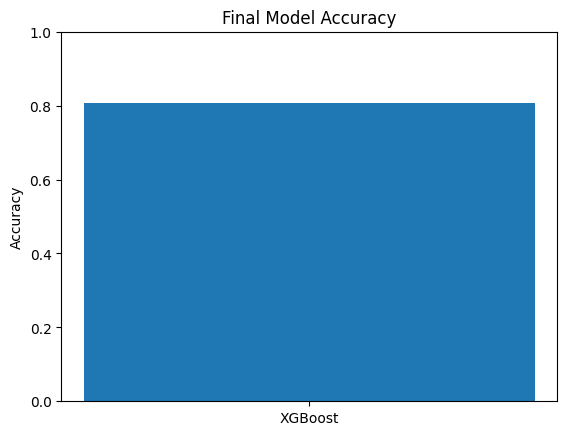

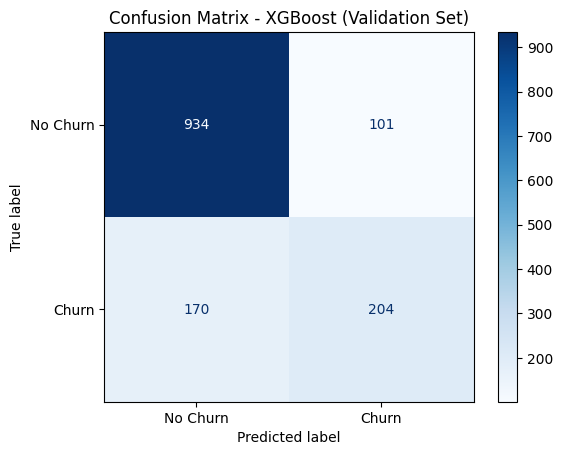

In [49]:

PLOTS_DIR = f"{ARTIFACTS_DIR}/plots"
os.makedirs(PLOTS_DIR, exist_ok=True)


final_model = best_xgb_pipeline


y_val_pred = final_model.predict(X_val)
y_val_prob = final_model.predict_proba(X_val)[:, 1]


# Accuracy

final_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Final Model Accuracy: {final_accuracy:.4f}")

plt.figure()
plt.bar(["XGBoost"], [final_accuracy])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Final Model Accuracy")
plt.savefig(f"{PLOTS_DIR}/xgb_accuracy.png", bbox_inches="tight")
plt.show()


# Confusion Matrix

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Churn", "Churn"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - XGBoost (Validation Set)")
plt.savefig(f"{PLOTS_DIR}/xgb_confusion_matrix.png", bbox_inches="tight")
plt.show()


**Observation:**  
While ROC-AUC indicates strong ranking capability, the confusion matrix reveals
the trade-off between false negatives (missed churners) and false positives.
Given business priorities, recall for churn customers is more critical than raw accuracy.


In [50]:
ARTIFACTS_DIR = "/content/drive/MyDrive/ML_internship_projects/ConnectTel-churn-prediction/churn_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

best_xgb_pipeline = xgb_grid.best_estimator_

joblib.dump(best_xgb_pipeline, f"{ARTIFACTS_DIR}/churn_pipeline.pkl")
joblib.dump(lr_pipeline, f"{ARTIFACTS_DIR}/logistic_pipeline.pkl")
joblib.dump(rf_pipeline, f"{ARTIFACTS_DIR}/rf_pipeline.pkl")

joblib.dump(X_val, f"{ARTIFACTS_DIR}/X_val.pkl")
joblib.dump(y_val, f"{ARTIFACTS_DIR}/y_val.pkl")

os.listdir(ARTIFACTS_DIR)


['X_test.pkl',
 'y_test.pkl',
 'xgb_booster.json',
 'logistic_pipeline.pkl',
 'y_val.pkl',
 'X_val.pkl',
 'churn_pipeline.pkl',
 'rf_pipeline.pkl',
 'plots']

In [51]:
xgb_model = best_xgb_pipeline.named_steps["model"]
booster = xgb_model.get_booster()

booster.save_model(
    f"{ARTIFACTS_DIR}/xgb_booster.json"
)
